In [1]:
date()

[1] "Tue Nov 15 18:51:48 2016"

# 8章
## 8.1

In [2]:
sapply(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

In [3]:
load("data/chap08/data.RData")
str(data)

 num [1:20] 4 3 4 5 5 2 3 1 4 0 ...


In [4]:
options(repr.plot.width = 4, repr.plot.height = 4)

In [5]:
table(data)

data
0 1 2 3 4 5 6 
1 2 1 3 6 6 1 

In [6]:
sum(data)

[1] 73

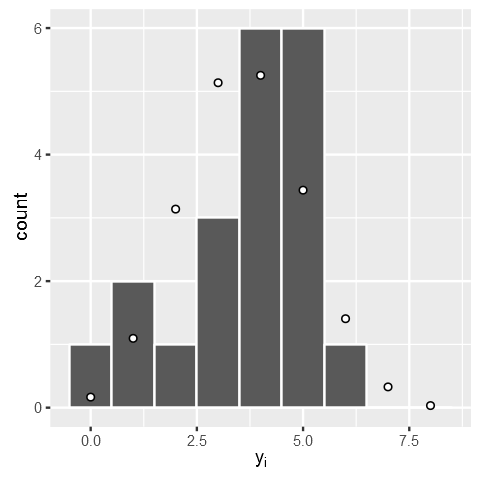

In [7]:
ggplot(data_frame(x = c(0, 8)), aes(x)) + 
    geom_histogram(data = data_frame(y = data), mapping = aes(x = y), binwidth = 1, colour = "white") + 
    stat_function(geom="point", n=9, fun = function(x, size, prob){20 * dbinom(x, size, prob)}, 
                  args = list(size = 8, prob = 0.45), shape = 21, fill = "white") + 
    xlab(expression("y"[i]))

$$ p(y_i | q) = \binom{8}{y_i} q^{y_i}(1 - q)^{8 - y_i} $$

$$ L(q) = p(\boldsymbol{Y} | q) = \prod\limits_i p(y_i | q) $$

$$ \log L(q) = \sum\limits_i \{ y_i \log q + (8 - y_i) \log(1 - q) \} + \mathrm{C} $$

In [8]:
logL <- function(q, y){
    sum(y * log(q) + (8 - y) * log(1 - q) + log(choose(8, y)))
}

In [9]:
logL(0.46, data)

[1] -37.75237

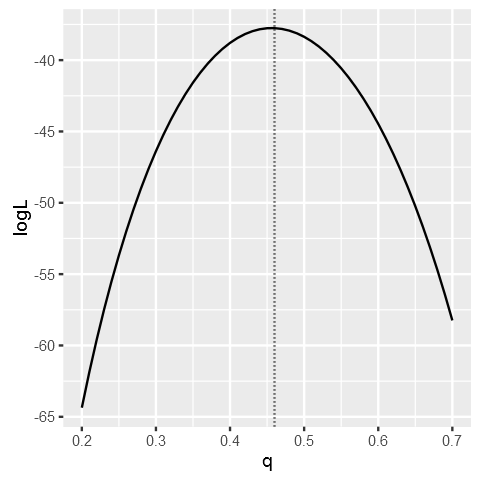

In [10]:
data_frame(q = seq(0.2, 0.7, 0.01)) %>>% 
    mutate(logL = sapply(q, function(x){logL(x, data)})) %>>% 
    ggplot(aes(x = q, y = logL)) + 
    geom_line() + 
    geom_vline(xintercept = 0.46, linetype = "dotted")

In [11]:
73 / 160

[1] 0.45625

$$ \hat{q} = \frac{\text{合計生存種子数}}{\text{合計調査種子数}} = \frac{\sum \boldsymbol{Y}}{8 \times 20} = \frac{73}{160} = 0.45625 $$

In [12]:
step_logL <- function(q, L, data){
    nq <- ifelse(sample(c(0, 1), size = 1, prob = c(0.5, 0.5)) == 0, q - 0.01, q + 0.01)
    nL <- logL(nq, data)
    if (nL > L){
        return(list(q = nq, L = nL))
    } else {
        return(list(q = q, L = L))
    }
}

In [15]:
do_step_logL <- function(start, nstep, data){
    qs <- numeric(nstep)
    qs[1] <- start
    pL <- logL(start, data)
    for(i in c(2:nstep)){
        q_L <- step_logL(qs[i - 1], pL, data)
        qs[i] <- q_L$q
        pL <- q_L$L
    }
    return(qs)
}

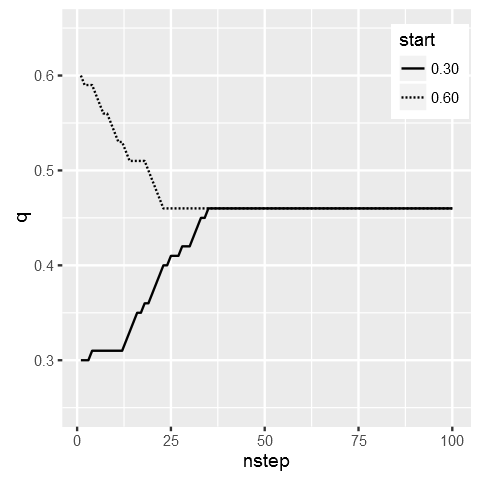

In [16]:
data_frame(nstep = c(1:100), q03 = do_step_logL(0.3, 100, data), q06 = do_step_logL(0.6, 100, data)) %>>% 
    gather(start, q, -nstep) %>>% 
    ggplot(aes(x = nstep, y = q, group = start, linetype = start)) + 
        geom_line() + 
        ylim(c(0.25, 0.65)) + 
        theme(
            legend.position = c(.9, .85)
        ) + 
        scale_linetype(labels = c("0.30", "0.60"))

## 8.3 メトロポリス法

In [19]:
step_metropolis <- function(q, L, data){
    nq <- ifelse(sample(c(0, 1), size = 1, prob = c(0.5, 0.5)) == 0, q - 0.01, q + 0.01)
    nL <- logL(nq, data)
    if (nL > L){
        return(list(q = nq, L = nL))
    } else {
        r <- exp(nL - L)
        if(sample(c(0, 1), size = 1, prob = c(r, 1 - r)) == 0){
            return(list(q = nq, L = nL))
            
        } else {
            return(list(q = q, L = L))            
        }
    }
}

In [20]:
metropolis <- function(start, nstep, data){
    qs <- numeric(nstep)
    qs[1] <- start
    pL <- logL(start, data)
    for(i in c(2:nstep)){
        q_L <- step_metropolis(qs[i - 1], pL, data)
        qs[i] <- q_L$q
        pL <- q_L$L
    }
    return(qs)
}

In [21]:
library(gridExtra)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [22]:
options(repr.plot.width = 10, repr.plot.height = 2)

In [25]:
step_metropolis(0.3, L = logL(0.4, data), data)

$q
[1] 0.3

$L
[1] -38.78862

In [26]:
metropolis(start = 0.3, nstep = 10, data = data)

[1] 0.30 0.29 0.28 0.28 0.29 0.30 0.31 0.30 0.31 0.30

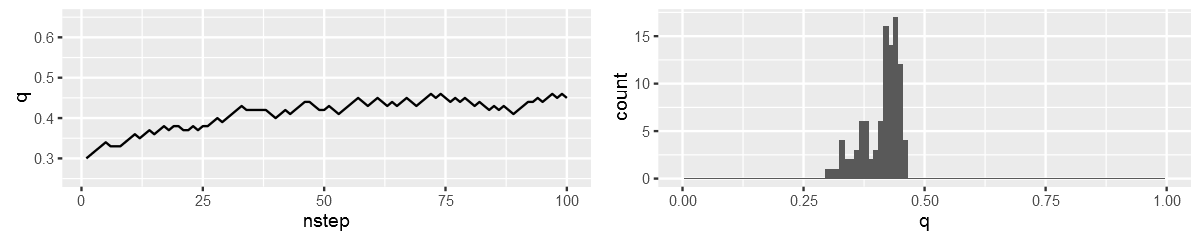

In [30]:
d.met1 <- data_frame(
    nstep = c(1:100), 
    q = metropolis(0.3, 100, data)
)
gp1 <- ggplot(data = d.met1, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = d.met1, aes(q)) + geom_histogram(binwidth = 0.01) + xlim(c(0, 1))
grid.arrange(gp1, gp2, ncol = 2)

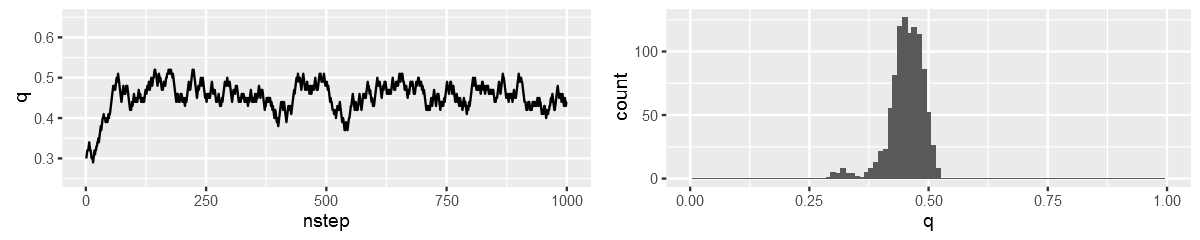

In [31]:
d.met2 <- data_frame(
    nstep = c(1:1000), 
    q = metropolis(0.3, 1000, data)
)
gp1 <- ggplot(data = d.met2, aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = d.met2, aes(q)) + geom_histogram(binwidth = 0.01) + xlim(c(0,1))
grid.arrange(gp1, gp2, ncol = 2)

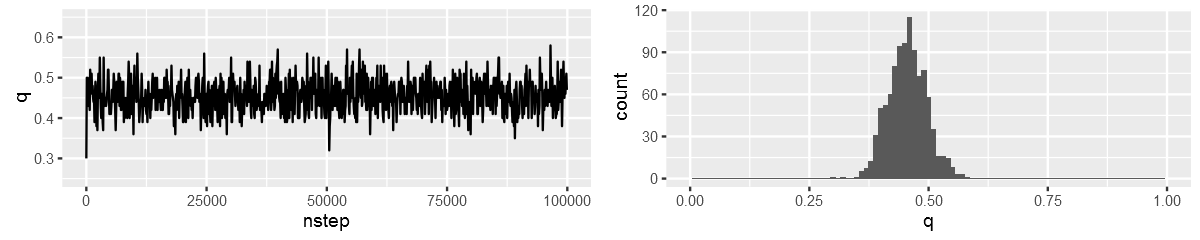

In [32]:
d.met3 <- data_frame(
    nstep = c(1:100000), 
    q = metropolis(0.3, 100000, data)
)
gp1 <- ggplot(data = slice(d.met3, seq(1, 100000, 100)), aes(x = nstep, y = q)) + geom_line() + ylim(c(0.25, 0.65))
gp2 <- ggplot(data = slice(d.met3, seq(1, 100000, 100)), aes(q)) + geom_histogram(binwidth = 0.01) + xlim(c(0, 1))
grid.arrange(gp1, gp2, ncol = 2)

In [33]:
d.met4 <- data_frame(
    nstep = c(1:500), 
    q1 = metropolis(0.1, 500, data), 
    q3 = metropolis(0.3, 500, data), 
    q4 = metropolis(0.4, 500, data), 
    q45 = metropolis(0.45, 500, data),    
    q5 = metropolis(0.5, 500, data), 
    q6 = metropolis(0.6, 500, data), 
    q7 = metropolis(0.7, 500, data) 
)

In [35]:
options(repr.plot.width = 8, repr.plot.height = 4)

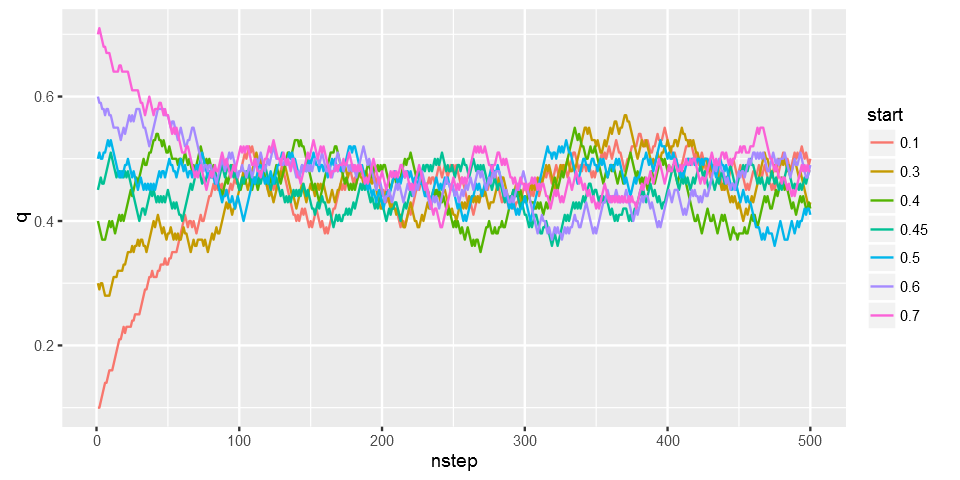

In [38]:
d.met4 %>>% gather(start, q, -nstep) %>>% 
    ggplot(aes(x = nstep, y = q, group = start, colour = start)) + 
    geom_line() + 
    scale_colour_discrete(labels = c("0.1", "0.3", "0.4", "0.45", "0.5", "0.6", "0.7"))

### 8.3.3